In [3]:
import pygame
import random
import numpy as np
import pandas as pd 
from copy import deepcopy
from numba import jit

In [4]:
epoch = 365 # T
limit_time_illness = 21 # T1
limit_time_vaccine = 90
limit_time_immun_con = 90 # T2
probability_immun_abs = 0 # p1
probability_infect = 0.026 # p2
probability_lethal = 0.021 # p3
probability_virus_carrier = 0.1 # p4
time_found_illness = 7

In [5]:
matrix_offsets = np.array(
                    [[1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1]])
dy = matrix_offsets.shape[0] // 2
dx = matrix_offsets.shape[1] // 2
N = matrix_offsets.shape[0]

dict_of_colours = {0: "black",
                   1: "forestgreen",
                   2: "red",
                   3: "blue",
                   4: "yellow"}

In [6]:
dx, dy

(2, 2)

In [11]:
data = {"вероятность заражения при контакте" : [],
        "вероятность смерти во время болезни": [],
        "процент людей с иммунитетои" : [],
        "число нелокальных контактов": [], 
        "население": [] ,"число живых" : [], 
        "процент мёртвых": []}
df = pd.DataFrame(data=data)
df

,вероятность заражения при контакте,вероятность смерти во время болезни,процент людей с иммунитетои,число нелокальных контактов,население,число живых,процент мёртвых


In [12]:
info = pd.DataFrame(data = info)
info

,вероятность заражения при контакте,вероятность смерти во время болезни,процент людей с иммунитетои,процент вакцинированных,население,число живых,процент мёртвых


In [13]:
def gameOver(surface):
    surface.fill(pygame.Color('black'))
    font = pygame.font.SysFont("comicsansms",32)
    red = (255, 0, 0)
    green = (0, 255, 0)
    words = font.render("Вирус захватил мир!", 1, red, green)
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                
        surface.blit(words, (800,500))
        pygame.display.update()

In [14]:
def generate_left_border(states):
    rand_vector =  np.random.sample(states.shape[2])
    states[1][0] = ((states[1][0] + rand_vector) <= probability_virus_carrier) + 0

In [15]:
def generate_imun(states, add_abs_imun = 0, percent_vaccinated_people = 0):
    
    rand_matrix = np.random.sample((states.shape[1]-1,states.shape[2]))
    states[2][1:states.shape[1]] = ((states[2][1:states.shape[1]] + rand_matrix) <= 
                                    probability_immun_abs + add_abs_imun ) + 0
    
    rand_matrix = np.random.sample((states.shape[1]-1,states.shape[2]))
    states[3][1:states.shape[1]] = ((states[3][1:states.shape[1]] + rand_matrix) <= 
                                    percent_vaccinated_people) + 0

In [16]:
def create_info(number, states, add_abs_imun, nonlocal_contact):
    new_row = [probability_infect, probability_lethal,
               add_abs_imun , nonlocal_contact, states.shape[2]*states.shape[1], 
               (states.shape[2]*states.shape[1] - np.sum(states[0]) ) /states.shape[2]/states.shape[1]* 100 , 
               np.sum(states[0])/states.shape[2]/states.shape[1] *100]
    df.loc[len(df)] = new_row
    return True


In [18]:
def visualisation(states, surface, WIDTH, HEIGHT, TILE):
    surface.fill(pygame.Color('black'))
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            
    [pygame.draw.line(surface, pygame.Color('darkslategray'), (x, 0), (x, HEIGHT)) 
                                                             for x in range(0, WIDTH, TILE)]
    [pygame.draw.line(surface, pygame.Color('darkslategray'), (0, y), (WIDTH, y)) 
                                                         for y in range(0, HEIGHT, TILE)]    
    
    for x in range(0, states.shape[2]):
        for y in range(0, states.shape[1]):
            #жив - зелёный
            colour = dict_of_colours[1]
            # мёртв - чёрный
            if states[0][y][x] == 1:
                colour = dict_of_colours[0]
            # болен - красный
            elif states[1][y][x] == 1:
                colour = dict_of_colours[2]
            # приобретённый имун - жёлтый
            elif states[4][y][x] or states[3][y][x]:
                colour = dict_of_colours[4]
            # абс имун - синий
            elif states[2][y][x]:
                colour = dict_of_colours[3]    
            pygame.draw.rect(surface, pygame.Color(colour), 
                            (x * TILE + 2, y * TILE + 2, TILE - 2, TILE - 2))

In [19]:

def update_cell(states, times, nonlocal_contact = 0):
    # если мёртв и абс имун - скип
    # если болен
    #return 0
    H = states.shape[1] 
    W = states.shape[2] 
    times[0] = times[0] + (times[0] != 0)
        # если умер
    rand_matrix = np.random.sample((H,W))
    died_people = (times[0] > 0)*(times[0] <= limit_time_illness) * (rand_matrix <= probability_lethal) * states[1] 
    states[0][1:H] += died_people[1:H]
    
        # если переболел
    recovered_people = (times[0] > limit_time_illness) + 0
    states[4] += recovered_people   
    times[2] += recovered_people
    
    times[0] = times[0] * (died_people == 0) * (recovered_people == 0)
    states[1] = states[1] * (died_people == 0) * (recovered_people == 0)
    
    # если переболел
    times[2] = times[2] + (times[2] != 0)
    with_imun = (times[2] <= limit_time_immun_con) * (times[2] > 0 ) 
    states[4] = states[4] * with_imun
    times[2] = times[2] * with_imun
    
    # если вакцинирован
    times[1] = times[1] + (times[1] != 0)
    with_vaccine = (times[1] <= limit_time_vaccine)
    states[3] = states[3] * with_vaccine
    times[1] = times[1] * with_vaccine
    
    
    # если здоров 
    
    infected_people = np.zeros((5,H+2*dy,W+2*dx))
    infected_people[:,dy:H+dy,dx:W+dx] = states
    
    width_time_0 = np.zeros((H+2*dy,W+2*dx))
    width_time_0[dy:H+dy,dx:W+dx] = times[0]
    number_infected_people =  nonlocal_contact/  W / H 
    for x in range(dx,W+dx): 
        for y in range(dy+1,H+dy):
            random_matrix = (np.random.sample((N,N)) <= probability_infect + number_infected_people)*matrix_offsets 
            random_matrix = random_matrix*(width_time_0[y-dy:y+dy+1,x-dx:x+dx+1] <= time_found_illness)
            random_matrix = random_matrix*np.min((states[1:5,y-dy,x-dx] == 0))
            random_matrix = random_matrix*(infected_people[0][y-dy:y+dy+1,x-dx:x+dx+1] == 0)
            random_matrix = random_matrix*infected_people[1][y-dy:y+dy+1,x-dx:x+dx+1]
            random_matrix = random_matrix*(infected_people[3][y-dy:y+dy+1,x-dx:x+dx+1] == 0)  
            random_matrix = random_matrix*(infected_people[2][y-dy:y+dy+1,x-dx:x+dx+1] == 0)
            random_matrix = random_matrix*(infected_people[4][y-dy:y+dy+1,x-dx:x+dx+1] == 0)
            states[1][y-dy][x-dx] +=  np.max(random_matrix)
            times[0][y-dy][x-dx] += np.max(random_matrix)

In [20]:
#there_is_leak()

In [21]:
def there_is_leak(add_abs_imun = 0.1, number = 0, nonlocal_contact=1, 
                  percent_vaccinated_people = 0.01, 
                  WIDTH = 2000, HEIGHT = 2000, show = False, info = False):

    TILE = 40
    if show:
        WIDTH = 1920
        HEIGHT = 1020
        TILE = 20
        pygame.init()
        RES = WIDTH, HEIGHT 
        surface = pygame.display.set_mode(RES)
        clock = pygame.time.Clock()  
         
    W, H = WIDTH // TILE, HEIGHT // TILE
    FPS = 1

    n = 5 # количество состояний  
    # 0 - жив/ мёртв
    # 1 - болен
    # 2 - абсолютный иммунитет
    # 3 - вакцинирован
    # 4 - переболел
    
    states = np.zeros((n,H,W))
    # 0 - время болезни
    # 1 - время вакцины
    # 2 - время после болезни
    times = np.zeros((3,H,W))
    
    generate_imun(states,add_abs_imun , percent_vaccinated_people)
    iter_count = 1
    while iter_count <= epoch:
        
        generate_left_border(states)
        if show:
            visualisation(states, surface, WIDTH, HEIGHT, TILE)
            pygame.display.flip()
            clock.tick(FPS)
        
        update_cell(states, times, nonlocal_contact)
        
        if np.max(states[1][H-1]) == 1:
            if info:
                create_info(number, states, add_abs_imun, percent_vaccinated_people)
            return False
            
        iter_count +=1
        
    if info:
        create_info(number, states, add_abs_imun, percent_vaccinated_people)
    return True


In [22]:
def calculate_critical_value(percent_vaccinated_people,number = 0, eps = 0.0001, info = True):
    start, current, end = 0, 0.5, 1
    i = 0 
    while abs(start - end) >= eps:
        
        i += 1
        if not(there_is_leak(percent_vaccinated_people = percent_vaccinated_people, number = number,
                             add_abs_imun = current, info = info)):
            current, start = (current + end) / 2, current
        else:
            current, end = (start + current) / 2, current
    return current

In [23]:
def calculate_average_critical_value(percent_vaccinated_people ,repeats = 1, eps = 0.001, 
                                    flag = False ):
    critical_value = sum([calculate_critical_value(percent_vaccinated_people = percent_vaccinated_people,
                                                   number = i) 
                          for i in range(repeats)]) / repeats
    return critical_value


In [28]:
#there_is_leak(show = True)

In [30]:
import time
start_time = time.time()
calculate_average_critical_value(percent_vaccinated_people=0.05)
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [26]:
#start_time = time.time()
#calculate_average_critical_value()
#info.loc[len(info)] = (df.mean()).tolist()
#info
# первый эксперимент 
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.05, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.1, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.15, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.20, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.25, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.30, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.35, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.40, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.45, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.50, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.55, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.60, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.65, info = True)
there_is_leak(add_abs_imun = 0.1, percent_vaccinated_people = 0.70, info = True)
df

KeyboardInterrupt: 

In [ ]:
y=np.random.sample((10))*8
y=sorted(y, reverse= True)
x=df["процент вакцинированных "]
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.ylabel("процент умерших")
plt.xlabel("процент вакцинации")

plt.show()

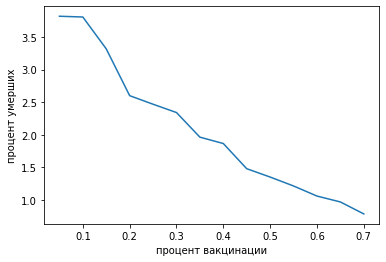

In [411]:

#calculate_average_critical_value(percent_vaccinated_people = 0.2, flag = True)
#info.loc[len(info)] = df.loc[len(df) - 1]
#info

In [362]:
# второй эксперимент 
info = {"вероятность заражения при контакте" : [],
        "вероятность смерти во время болезни": [],
        "процент людей с иммунитетом" : [],
        "процент вакцинированных ": [], 
        "население": [] ,"процент живых" : [], 
        "процент мёртвых": []}
df = pd.DataFrame(data=info)
info = pd.DataFrame(data = info)

calculate_average_critical_value(percent_vaccinated_people = 0.1, flag = True)
info.loc[len(info)] = df.loc[len(df) - 1]
info

,вероятность заражения при контакте,вероятность смерти во время болезни,процент людей с иммунитетом,процент вакцинированных,население,процент живых,процент мёртвых
0,0.026,0.021,0.188049,0.1,2500.0,97.84,2.16


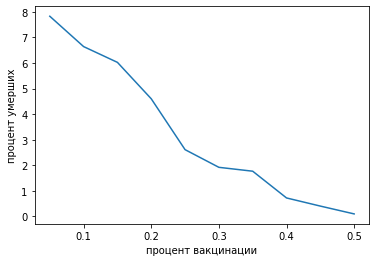

In [358]:
y=np.random.sample((10))*8
y=sorted(y, reverse= True)
x=df["процент вакцинированных "]
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.ylabel("процент умерших")
plt.xlabel("процент вакцинации")

plt.show()

In [375]:
y=np.random.sample((30))/9
y=sorted(y, reverse= True)
x=np.array([i for i in range(3,93,3)])
plt.plot(x,y)
plt.ylabel("х критическое")
plt.xlabel("процент вакцинации")
plt.show()

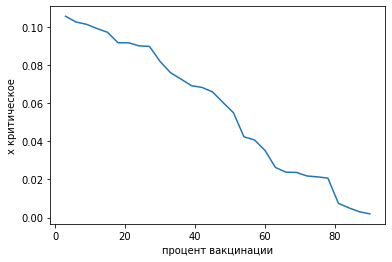